In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from collections import Counter
import pickle as pkl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, Dataset, SubsetRandomSampler

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from torchtext.vocab import Vocab

from chord_rec.models.seq2seq.Seq2Seq import BaseSeq2Seq
from chord_rec.models.seq2seq.Encoder import BaseEncoder
from chord_rec.models.seq2seq.Decoder import BaseDecoder, AttnDecoder

In [5]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device("cpu")
# device = torch.device("cpu")

In [6]:
class Vec21Dataset(Dataset):
    def __init__(self, note_vec_seq, chord_seq, vocab):
        'Initialization'
        self.note_vec_seq = note_vec_seq
        self.chord_seq = chord_seq
        self.vocab = vocab

    def __len__(self):
        'Get the total length of the dataset'
        return len(self.note_vec_seq)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        
        
        return self.note_vec_seq[index], self.vec_encode(self.chord_seq[index])
    
    def encode(self, x):
        return self.vocab.stoi[x]


    def vec_encode(self, x):
        return np.vectorize(self.encode)(x)
    

    def decode(self, x):
        return self.vocab.itos[x]


    def vec_decode(self, x):
        return np.vectorize(self.decode)(x)
    

In [7]:
data = pkl.load(open('bach_reduced_seq2seq_4mm_new.pkl',"rb"))

note_seq, chord_seq = [],[]
max_seq_len = 0
data_num = 0
for file in data:
    data_num += len(file)
    for window in file:
        note_seq.append(window[0])
        chord_seq.append(window[1])
        max_seq_len = max(max_seq_len, len(window[1]))

In [8]:
note_padding_vec = np.full(len(note_seq[0][0]), -1).reshape(1,-1) # should be 45; not sure if -1 is good
note_ending_vec = np.ones(len(note_seq[0][0])).reshape(1,-1) # should be 45
note_starting_vec = np.zeros(len(note_seq[0][0])).reshape(1,-1) # should be 45

chord_start = "<sos>"
chord_padding = "<pad>"
chord_end = "<eos>"

padded_note_seq = []
padded_chord_seq = []
for i in range(len(note_seq)):
    len_diff = max_seq_len - len(note_seq[i])

    temp_note_vec = np.vstack((note_starting_vec, np.array(note_seq[i]), note_ending_vec, np.repeat(note_padding_vec, len_diff , axis = 0)))
    padded_note_seq.append(temp_note_vec)
    
    temp_chord_vec = np.hstack((chord_start, np.array(chord_seq[i]), chord_end, np.repeat(chord_padding, len_diff , axis = 0)))
    padded_chord_seq.append(temp_chord_vec)

In [9]:
stacked_note_seq = np.stack(padded_note_seq, axis = 0)
stacked_chord_seq = np.vstack(padded_chord_seq)


In [10]:
SEED = 0
VAL_SIZE = 0.2
TEST_SIZE = 0.2

In [11]:
note_vec = np.asarray(stacked_note_seq, dtype = np.float32)

In [12]:
chord_vocab = Vocab(Counter(list(stacked_chord_seq.flatten())))

In [13]:
vec_size = note_vec.shape[-1]
vocab_size = len(chord_vocab.stoi)

In [14]:
note_train, note_test, chord_train, chord_test \
    = train_test_split(note_vec, stacked_chord_seq, test_size=TEST_SIZE, random_state=SEED)

note_train, note_val, chord_train, chord_val \
    = train_test_split(note_vec, stacked_chord_seq, test_size= VAL_SIZE/ (1-TEST_SIZE), random_state=SEED)

In [15]:
train_dataset = Vec21Dataset(note_train, chord_train, chord_vocab)
val_dataset = Vec21Dataset(note_val, chord_val, chord_vocab)
test_dataset = Vec21Dataset(note_test, chord_test, chord_vocab)

In [16]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size =  batch_size, drop_last = True)
test_loader =  DataLoader(test_dataset, batch_size =  batch_size, drop_last = True)

In [22]:
input_size = vec_size
emb_size = vec_size
encoder_hidden_size = 128
decoder_hidden_size = 128
encoder_dropout = 0.5
decoder_dropout = 0.5
n_layers = 2
output_size = vocab_size
model_type = "LSTM"

encoder = BaseEncoder(input_size, emb_size, encoder_hidden_size, decoder_hidden_size, n_layers, dropout = encoder_dropout)
decoder = BaseDecoder(emb_size, decoder_hidden_size, output_size, n_layers, dropout = decoder_dropout)
# decoder = AttnDecoder(emb_size, decoder_hidden_size, output_size, n_layers, max_seq_len, dropout = decoder_dropout)
model = BaseSeq2Seq(encoder, decoder, device)

In [16]:
criterion = nn.CrossEntropyLoss(ignore_index = chord_vocab.stoi["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)

In [17]:
# model.state_dict = torch.load("sears_reduce_20warm80epoch_s2s.sdict")

In [85]:
# decay_run = 80
# warm_up = 10
post_run = 50

decay_run = 0
warm_up = 0

epochs = warm_up +decay_run + post_run
train_losses = []
val_losses = []
tf_ratios = np.hstack((np.full(warm_up, 1), np.flip(np.linspace(0, 0.75, decay_run)), np.zeros(post_run)))
print(tf_ratios.shape)
clip = 1

for epoch in range(1,epochs+1):
    total_loss = 0
    
    model.train()
    train_pgbar = tqdm(train_loader)
    for idx, (note, chord) in enumerate(train_pgbar):
        tf = np.random.random()<tf_ratios[epoch - 1]
        pred = model(note.to(device), chord.long().to(device), teacher_forcing = tf, start_idx = chord_vocab.stoi["<sos>"])
        pred = pred.permute(0,2,1)
        loss = criterion(pred, chord.long().to(device))

        optimizer.zero_grad()
        if loss.item() != 0:
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        
#         s = "Epoch: {} Train Loss: {:.5f}".format(epoch, loss.item())
#         tqdm.write(s)
        train_pgbar.set_postfix({'Epoch': epoch, 'Train Loss': "{:.5f}".format(loss.item())})
        total_loss += loss.item()
    print("Total Training Loss: %.2f" % total_loss)
    train_losses.append(total_loss/len(train_loader))
    total_loss = 0
    
    model.eval()
    val_pgbar = tqdm(val_loader)
    for idx, (note, chord) in enumerate(val_pgbar):

        pred = model(note.to(device), chord.long().to(device), teacher_forcing = False, start_idx = chord_vocab.stoi["<sos>"])
        loss = criterion(pred.permute(0,2,1), chord.long().to(device))
        
#         s = "Epoch: {} Val Loss: {:.5f}".format(epoch, loss.item())
#         tqdm.write(s)
        val_pgbar.set_postfix({'Epoch': epoch, 'Val Loss': "{:.5f}".format(loss.item())})
        total_loss += loss.item()
    print("Total Validation Loss: %.2f" % total_loss)
    val_losses.append(total_loss/len(val_loader))

(50,)



Total Training Loss: 153.25



Total Validation Loss: 92.20



Total Training Loss: 152.66



Total Validation Loss: 92.58



Total Training Loss: 152.14



Total Validation Loss: 93.20



Total Training Loss: 151.79



Total Validation Loss: 93.11



Total Training Loss: 152.01



Total Validation Loss: 93.86



Total Training Loss: 150.93



Total Validation Loss: 93.59



Total Training Loss: 150.74



Total Validation Loss: 94.36



Total Training Loss: 150.25



Total Validation Loss: 93.96



Total Training Loss: 148.86



Total Validation Loss: 93.82



Total Training Loss: 148.38



Total Validation Loss: 93.73



Total Training Loss: 148.46



Total Validation Loss: 94.29



Total Training Loss: 147.45



Total Validation Loss: 94.42



Total Training Loss: 148.57



Total Validation Loss: 94.09



Total Training Loss: 148.95



Total Validation Loss: 94.93



Total Training Loss: 147.87



Total Validation Loss: 95.14



Total Training Loss: 148.43



Total Validation Loss: 94.48



Total Training Loss: 146.69



Total Validation Loss: 94.62



Total Training Loss: 147.70



Total Validation Loss: 95.83



Total Training Loss: 147.12



Total Validation Loss: 94.92



Total Training Loss: 147.02



Total Validation Loss: 95.24



Total Training Loss: 148.28



Total Validation Loss: 95.82



Total Training Loss: 150.09



Total Validation Loss: 95.94



Total Training Loss: 152.47



Total Validation Loss: 96.52



Total Training Loss: 151.04



Total Validation Loss: 96.21



Total Training Loss: 149.74



Total Validation Loss: 94.62



Total Training Loss: 147.40



Total Validation Loss: 95.14



Total Training Loss: 144.97



Total Validation Loss: 95.09



Total Training Loss: 142.93



Total Validation Loss: 95.33



Total Training Loss: 141.70



Total Validation Loss: 95.82



Total Training Loss: 141.11



Total Validation Loss: 95.93



Total Training Loss: 140.04



Total Validation Loss: 96.39



Total Training Loss: 139.12



Total Validation Loss: 95.88



Total Training Loss: 138.49



Total Validation Loss: 95.99



Total Training Loss: 137.24



Total Validation Loss: 96.33



Total Training Loss: 136.92



Total Validation Loss: 96.75



Total Training Loss: 136.74



Total Validation Loss: 97.09



Total Training Loss: 136.91



Total Validation Loss: 97.08



Total Training Loss: 136.27



Total Validation Loss: 97.64



Total Training Loss: 137.26



Total Validation Loss: 97.55



Total Training Loss: 136.33



Total Validation Loss: 98.59



Total Training Loss: 136.33



Total Validation Loss: 99.33



Total Training Loss: 137.48



Total Validation Loss: 100.78



Total Training Loss: 138.78



Total Validation Loss: 100.71



Total Training Loss: 140.66



Total Validation Loss: 100.75



Total Training Loss: 141.19



Total Validation Loss: 98.40



Total Training Loss: 142.18



Total Validation Loss: 98.29



Total Training Loss: 139.81



Total Validation Loss: 98.04



Total Training Loss: 137.43



Total Validation Loss: 97.65



Total Training Loss: 135.21



Total Validation Loss: 97.72



Total Training Loss: 133.49



Total Validation Loss: 97.91


In [86]:
import matplotlib.pyplot as plt

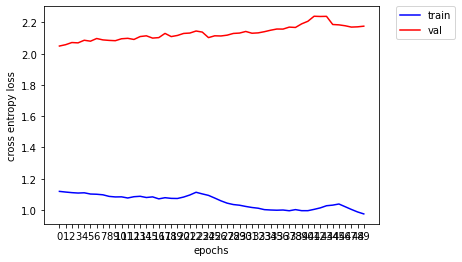

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(train_losses, color = "b", label = "train")
plt.plot(val_losses, color = "r", label = "val")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel('epochs')
ax.set_ylabel('cross entropy loss') 
xint = range(len(train_losses))

plt.xticks(xint)
plt.show()

In [88]:
model.eval()
all_pred2 = []
all_label2 = []
for idx, (note, chord) in enumerate(tqdm(val_loader)):
        pred = model(note.to(device), chord.long().to(device), teacher_forcing = False, start_idx = chord_vocab.stoi["<sos>"])
        pred = pred.detach().cpu().numpy().argmax(axis = -1)
        
        label = chord.detach().cpu().numpy()
        pred[:,0] = np.full(len(pred), chord_vocab.stoi["<sos>"])
        all_pred2.append(val_dataset.vec_decode(pred))
        all_label2.append(val_dataset.vec_decode(label))

In [89]:
all_pred2 = np.vstack(all_pred2)
all_label2 = np.vstack(all_label2)

In [90]:
all_pred2[0]

array(['<sos>', 'E major', 'A major', 'D major', 'B minor', 'B minor',
       'B minor', 'B minor', 'B minor', 'B minor', 'B minor', 'A major',
       'A major', 'D major', 'D major', 'B minor', 'B minor seventh',
       'B minor seventh', 'E major', 'E major', 'E major', '<eos>',
       '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'], dtype='<U27')

In [91]:
all_label2[0]

array(['<sos>', 'E major', 'A major', 'D major', 'D major', 'A# minor',
       'B minor', 'B minor', 'C# half-diminished seventh', 'F# major',
       'B minor', 'A major', 'E major', 'A major', 'F# minor', 'F# minor',
       'B minor seventh', 'B minor seventh', 'E major', 'E major',
       'E major', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
       '<pad>'], dtype='<U27')

In [92]:
decoded_preds = all_pred2
decoded_chords = all_label2

In [93]:
decoded_preds

array([['<sos>', 'E major', 'A major', ..., '<eos>', '<eos>', '<eos>'],
       ['<sos>', 'D major', 'A major', ..., '<eos>', '<eos>', '<eos>'],
       ['<sos>', 'Eb major', 'Eb major', ..., '<eos>', '<eos>', '<eos>'],
       ...,
       ['<sos>', 'Bb minor', 'C dominant seventh', ..., '<eos>', '<eos>',
        '<eos>'],
       ['<sos>', 'B minor', 'E dominant seventh', ..., '<eos>', '<eos>',
        '<eos>'],
       ['<sos>', 'Gb major', 'Gb major', ..., '<eos>', '<eos>', '<eos>']],
      dtype='<U27')

In [94]:
mask = (decoded_preds != "<sos>") & (decoded_preds != "<eos>") & (decoded_preds != "<pad>")
masked_preds = decoded_preds[mask]
masked_chords = decoded_chords[mask]

print(np.sum(masked_preds == masked_chords) / len(masked_chords))

0.46310494503265587


In [95]:
print(masked_chords)

['E major' 'A major' 'D major' ... 'Db major' 'Eb minor' 'Eb minor']


In [96]:
masked_preds == masked_chords

array([ True,  True,  True, ..., False, False, False])

In [97]:
# SEPERATE EVALUATION OF ROOT AND QUALITY AFTER DECODING
# seperate all pred 
root_preds = decoded_preds.copy()
quality_preds = decoded_preds.copy()
for r_id in range(decoded_preds.shape[0]):
    for c_id in range(decoded_preds.shape[1]):
        sp = decoded_preds[r_id, c_id].split(' ')
        root_preds[r_id, c_id] = sp[0]
        quality_preds[r_id, c_id] = ' '.join(sp[1:])
    
root_labels = decoded_chords.copy()
quality_labels = decoded_chords.copy()
for r_id in range(decoded_chords.shape[0]):
    for c_id in range(decoded_chords.shape[1]):
        sp = decoded_chords[r_id, c_id].split(' ')
        root_labels[r_id, c_id] = sp[0]
        quality_labels[r_id, c_id] = ' '.join(sp[1:])
# # seperate all lable 
# root_labels = []
# quality_labels = []
# for c in decoded_chords:
#     sp = c.split(' ')
#     root_labels.append(sp[0])
#     quality_labels.append(' '.join(sp[1:]))
    
# root_labels = np.asarray(root_labels)
# quality_labels = np.asarray(quality_labels)

In [98]:
mask = (root_preds != "<sos>") & (root_preds != "<eos>") & (root_preds != "<pad>")
root_preds = root_preds[mask]
quality_preds = quality_preds[mask]
root_label = root_labels[mask]
quality_labels = quality_labels[mask]

In [99]:
np.sum(root_preds == root_label) / len(root_preds)

0.5407082876962395

In [100]:
np.sum(quality_preds == quality_labels) / len(quality_preds)

0.6291428339621111

In [84]:
torch.save(model.state_dict(), "bach_reduced_10warm80epoch50post_s2s.sdict")

In [63]:
# EVALUATE root AFTER DECODING
sum(1 for x,y in zip(root_preds, root_labels) if x == y) / len(root_labels)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# EVALUATE quality AFTER DECODING
sum(1 for x,y in zip(quality_preds, quality_labels) if x == y) / len(quality_labels)

In [ ]:
co = Counter(chords)

In [ ]:
most_common_chord = list(list(zip(*co.most_common(20)))[0])

In [ ]:
for i in range(len(decoded_preds)):
    if decoded_preds[i] not in most_common_chord:
        decoded_preds[i] = "others"
    if decoded_chords[i] not in most_common_chord:
        decoded_chords[i] = "others"

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sn

In [64]:
cm = confusion_matrix(decoded_chords, decoded_preds, normalize = "true", labels = most_common_chord + ["others"])

NameError: name 'confusion_matrix' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(13,10)) 

sn.heatmap(cm, annot=False)
ax.set_xticklabels(most_common_chord + ["others"])
ax.set_yticklabels(most_common_chord + ["others"])
plt.yticks(rotation=0) 
plt.xticks(rotation="vertical") 
plt.show()
fig.savefig("confusion_bachhaydn_baseline.pdf", format = "pdf")

In [ ]:
torch.save(model.state_dict(), "baseline_bach_and_haydn.pt")

In [ ]:
symbol, num = list(zip(*co.most_common(50)))
symbol = list(symbol)
num = list(num)

In [ ]:
symbol += ['others']
num += [np.sum(list(co.values())) - np.sum(num)]

In [ ]:
num/=np.sum(num)

In [ ]:
plt.subplots(figsize=(13,10)) 
x_pos = [i for i, _ in enumerate(symbol)]

plt.bar(x_pos, num)
plt.xlabel("Chord Symbol")
plt.ylabel("Occurance")
plt.title("bach chorales Chord Distribution")

plt.xticks(x_pos, symbol, rotation = "vertical")

plt.show()